In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
from IPython.display import Image
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
#pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_73125/2466413295.py:30: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [3]:
dogs = pd.read_csv('data/akc.csv').dropna()
earn = (pd.read_csv('data/earnings2020.csv')
        .replace([1, 2, 3, 4, 5], ["<HS", "HS", "<BA", "BA", ">BA"]))

sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_73125/3671555367.py:5: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


## Facilitating Meaningful Comparisons

The same data can be visualized many different ways. How can we decide between two plots of the same data? Generally speaking, your plot should help a reader make meaningful comparisons. In this section, we go over several useful principles that can improve the clarity of your plots.

### Emphasize the Important Difference

Whenever we make a plot that compares groups, we should ask: does the plot emphasize the important difference? As a rule of thumb, it's easier for readers to see differences when they are aligned in ways that make the comparisons easier to read. Let's look at an example.

The US Bureau of Labor Statistics publishes data on income. We've taken the 2020 median full-time-equivalent weekly earnings for people over 25 and plotted them below. We've split people into groups by education level and sex.

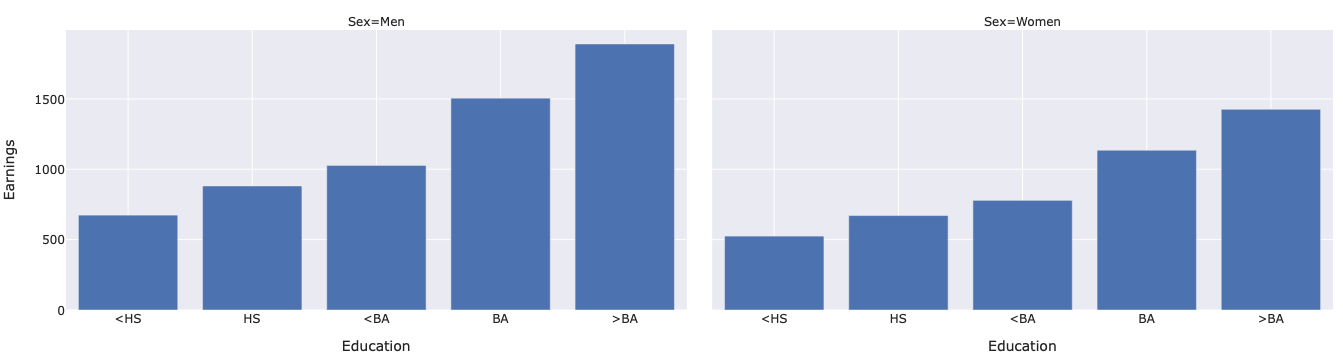

In [4]:
labels = {'educ': 'Education', 'income': 'Earnings', 'gender': 'Sex'}
fig = px.bar(earn, x='educ', y='income', facet_col='gender', labels=labels, width=450, height=250)
margin(fig, t=30)

These bar plots show that earnings increase with more education. But a more interesting comparison is between men and women of the same education level. We can try grouping the bars differently to focus instead on this comparison.

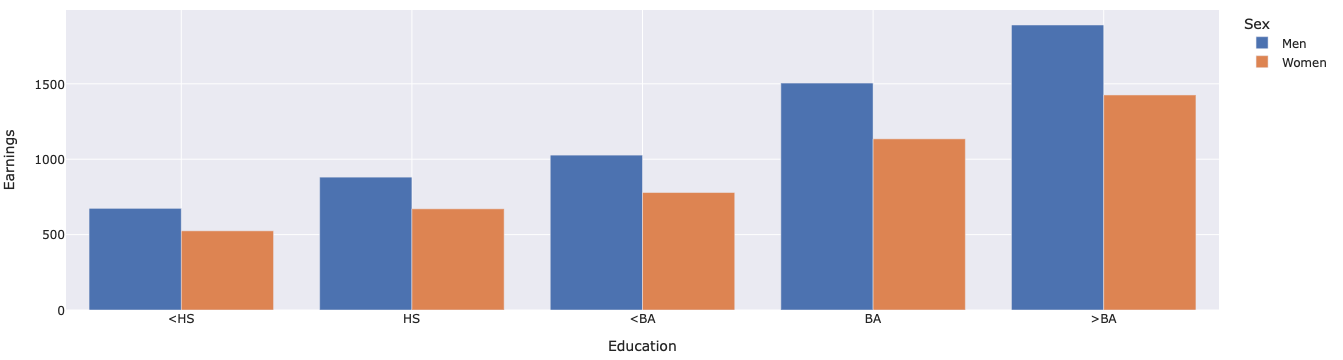

In [5]:
fig = px.bar(earn, x='educ',y='income',color='gender',barmode='group',labels=labels,width=450,height=250)
fig

This plot is much better, we can more easily compare the earnings of men and women for each level of education. However, we can make this difference even more clear using vertical alignment. Instead of bars, we use dots so that we can align the dots vertically for each education level.

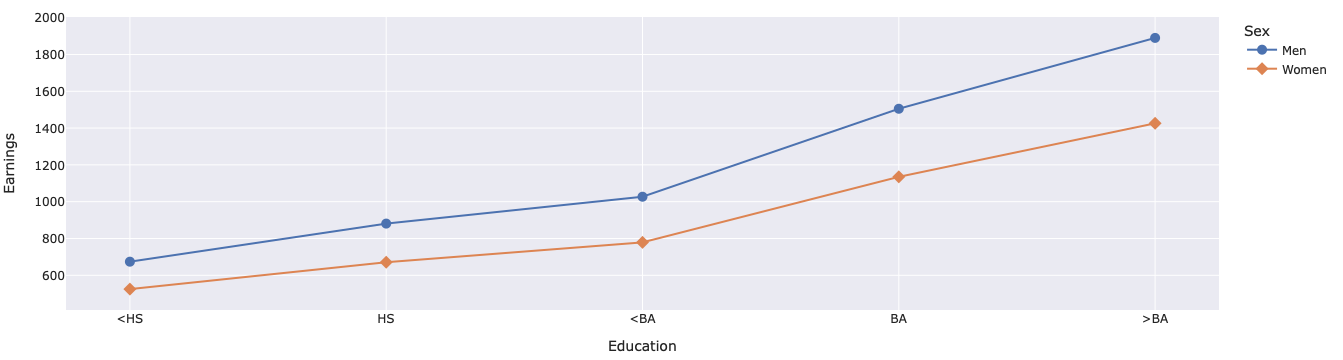

In [6]:
fig = px.line(earn, x='educ',y='income',color='gender', symbol='gender',
              labels=labels,
              markers=True,
              width=450,height=250)
fig.update_traces(marker=dict(size=10))
fig

This plot most clearly shows the most important difference. It's visually clear that in 2020, the median weekly earnings for men was higher than the earnings for women at each education level, and that this gap grows at higher education levels. We considered three plots in this example that all plot the same data, but they are not the same in how readily you can see the message in the plot. We prefer the last one because it aligns the income differences vertically, making them easier to compare.

Notice that in making all three plots, we ordered the education categories from the least to greatest number of years of education. This ordering makes sense because education level is ordinal. What happens when we are comparing against a categorical variable that does not have a natural ordering? This is the topic of the next section.

## Ordering Groups
In plots that compare groups of observations, we want to choose an ordering of the groups that helps us make these comparisons. The exception to this principle is when the groups come from an ordinal feature, like education level. In other words, for nominal features we adjust the ordering to facilitate comparisons, but we leave ordinal data in their natural order.

In general, for bar plots, it's good practice to order the bars according to their height. And for box plots and strip charts, we typically order them according to the group medians. We provide examples of each. The two bar plots below each compare the mean lifespan for groups of dog breeds. We prefer the plot on the right since it has ordered bars, which make it easier to compare longevity across groups. We don't have to squint to guess whether herding breeds have a shorter lifespan than toy breeds.

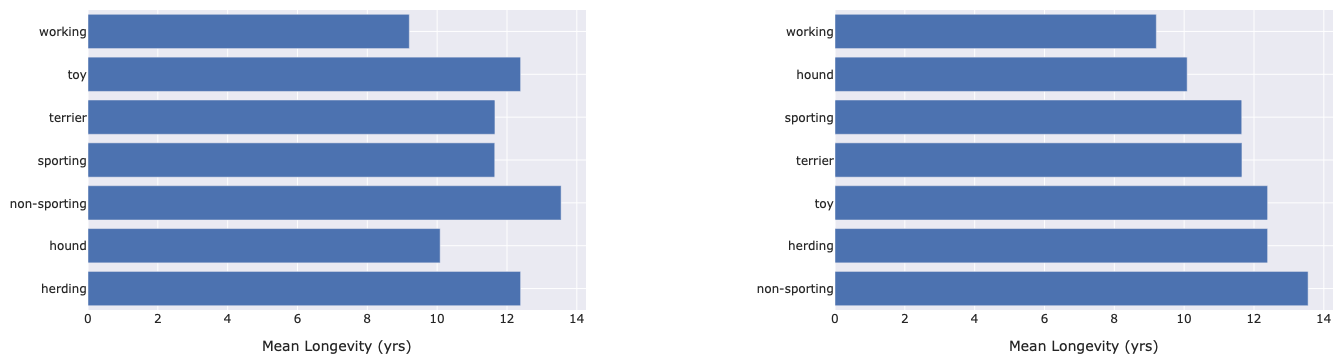

In [7]:
lons = dogs.groupby('group')[['longevity']].mean().reset_index()
f1 = px.bar(lons, x='longevity', y='group')
f2 = px.bar(lons.sort_values('longevity', ascending=False),
            x='longevity', y='group')

fig = left_right(f1, f2, width=600, height=200, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Mean Longevity (yrs)')
fig

As another example, the two sets of box plots below each compare the distribution of price for houses in different cities in the San Francisco East Bay. We prefer the plot on the right since it has ordered boxes, according to the median price for each city. Again, this ordering makes it easier to compare distributions across groups, in this case cities. We see that the lower quartile and median price in Albany and Walnut Creek are roughly the same but the prices in Walnut Creek have greater right skew.

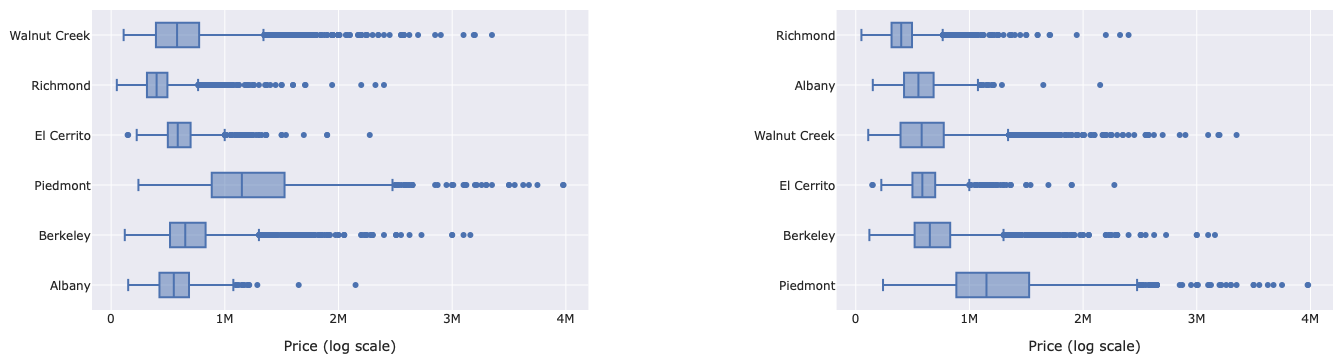

In [8]:
cities = ['Richmond', 'El Cerrito', 'Albany', 'Berkeley',
          'Walnut Creek', 'Lamorinda', 'Piedmont']

sfh_cities = sfh.query('city in @cities')


meds = (sfh_cities.groupby('city')
 ['price']
 .transform('median')
)
by_medians = (sfh_cities.assign(med=meds)
 .sort_values('med', ascending=False)
)

f1 = px.box(sfh_cities, x='price', y='city', log_x=True)
f2 = px.box(by_medians, x='price', y='city', log_x=True)
fig = left_right(f1, f2, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Price (log scale)')
fig

When possible, ordering bars by height in a bar plot and box plots by medians makes it easier for you to make comparisons across groups. Another technique used for presenting grouped data is stacking. We describe stacking in the next section and provide examples that are meant to convince you to stear away from this sort of plot.

## Avoid Stacking
The figure below shows a stacked bar plot where there is one bar for each city and these bars are divided according to the proportion of houses sold that have 1, 2, 3, ..., 8+ bedrooms. This is called a stacked bar plot. In this particular version, each bar has the same height of 1 because the segments of eac bar are the proportions of houses with 1, 2, 3,... bedrooms in a city.

<AxesSubplot:xlabel='city'>

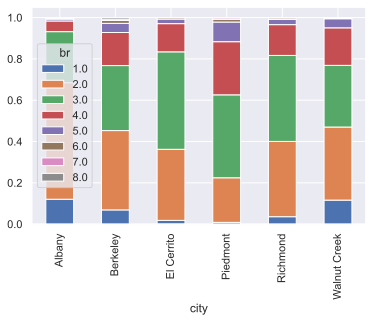

In [9]:
#px.bar(sfh_cities, x='city', y='br', color = 'br', barmode='stack')
br_crosstab = pd.crosstab(sfh_cities.city, sfh_cities.br, margins=False, normalize='index')

br_crosstab.plot(kind='bar', stacked=True)

It's easy to compare the proportion of one bedroom houses in each of the cities, but the comparison of, say, four bedroom houses is more difficult because the bottom of the segment that represents four-bedroom houses are not aligned horizontally which means that our eyes must judge the lengths of the segments as they move up and down, rather than simply scanning across the top of each segment. This up and down movement is called "jiggling the baseline".

Stacked line plots are even more difficult to read as the distance from one curve to another wiggles up and down. The plot below show carbon dioxide (CO2) emissions from 1950 to 2012 for the 10 countries with the highest emissions.

In [10]:
co2 = pd.read_csv("data/co2_by_country.csv",encoding= 'unicode_escape',skiprows = 2,
                  names = ["Country", "Year", "CO2"])
last_year = co2.Year.iloc[-1]
q = (f"Country not in ['World', 'European Union (15)', 'European Union (28)']"
     f"and Year == {last_year}")
top10_lasty = co2.query(q).sort_values('CO2', ascending=False).iloc[:10]
top10 = co2[co2.Country.isin(top10_lasty.Country) & (co2.Year >= 1950)]

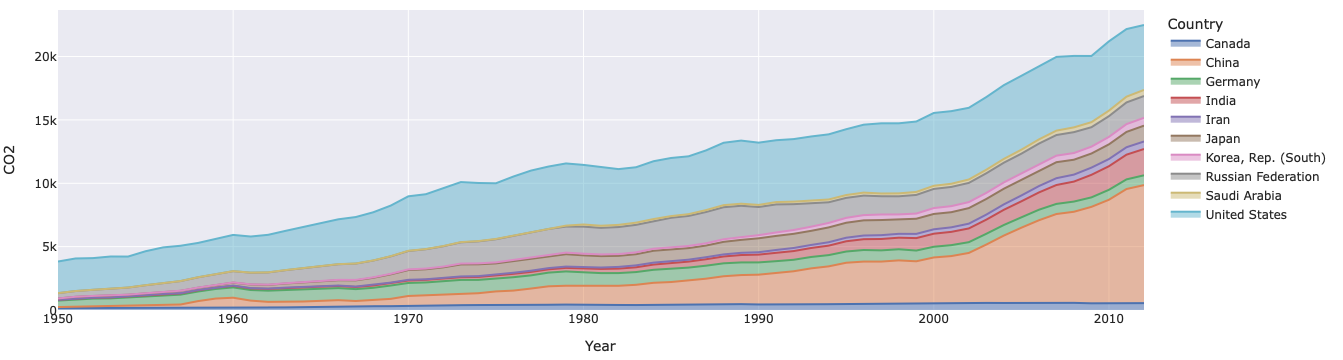

In [11]:
fig = px.area(top10, x='Year', y='CO2', 
              color = 'Country', line_group = 'Country',
              width=600, height=350)
fig

Since the lines are stacked on top of each other, it's very hard to see how the emissions for a particular country has changed and it's hard to compare countries. Instead, we can plot each country's line separately without stacking, as the plot below illustrates.

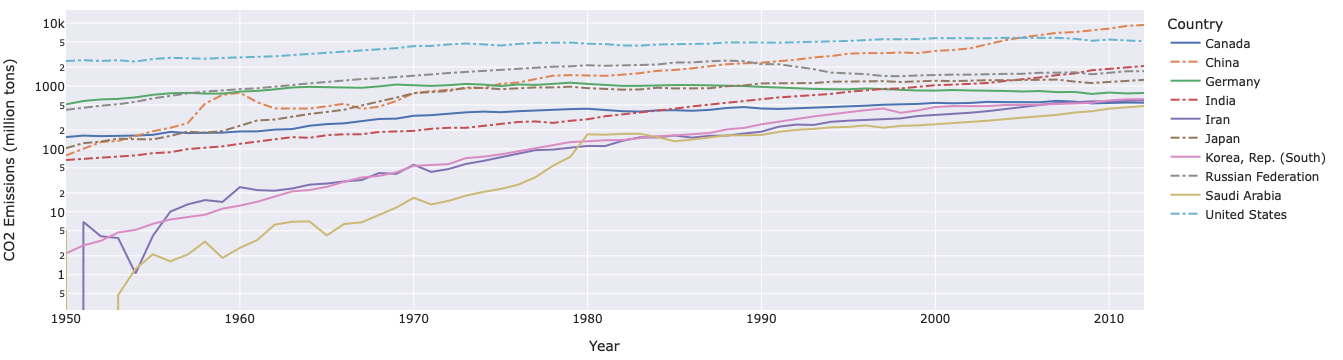

In [12]:
fig =px.line(top10, x='Year',y='CO2',color='Country',
             log_y=True,
             width=600,height=350)
# To make some lines dashed:
from itertools import cycle
styles = cycle([None, 'dashdot'])
for i in range(10):
    fig.update_traces(selector=i, 
                      line = dict(dash=next(styles)))
fig.update_yaxes(title_text='CO2 Emissions (million tons)')
fig

Now, it's much easier to see changes for individual countries and to compare countries because we need judge only y-axis positions rather than line segments with a moving baseline. We see that some countries have had flat rates of growth in CO2 emissions (on a log scale), such as the United States and Japan, while others have increased much faster, like China and India, and Germany has slowed its CO2 emissions. These aspects were nearly impossible to see when a country's baseline jiggled across time.

Stacked bar and line plots hinder comparisons because they lack a constant baseline.

In both of these plots, to make it easier to tell one country from the next, we have used different line types and colors. Choosing colors to facilitate comparisons relies on many considerations. This is the topic of the next section.

## Selecting a Color Palette

Choosing colors also plays an important role in data visualization. We want to avoid overly bright or dark colors so that we don't strain readers' eyes. We should also avoid color palettes that might be difficult for color-blind people---7-10% of people (mostly males) are red-green color-blind.

For categorical data, we want to use a color palette that can clearly distinguish between categories. One example is shown in {numref}Figure %s <qual_palette>, which is incidentally the color palette we use for visualizations in this book.

In [13]:
Image(url= "figures/qual_palette.svg",width=600, height=500)

Above is an example color palette for categorical data from the seaborn Python package

For numeric data, we want to use a sequential color palette that emphasizes one side of the spectrum more than the other or a diverging color palette that equally emphasizes both ends of the spectrum and deemphasizes the middle. An example of a sequential palette is shown in {numref}Figure %s <quant_palette>, and an example of a diverging palette in {numref}Figure %s <div_palette>.

In [14]:
Image(url= "figures/quant_palette.png",width=600, height=500)

An sequential color palette for numeric data.

In [15]:
Image(url= "figures/div_palette.png",width=600, height=500)

An diverging color palette for numeric data.

We choose a sequential palette when we want to emphasize either low or high values, like cancer rates. We choose a diverging palette when we want to emphasize both extremes, like for two-party election results.

It's important to choose a perceptually uniform color palette. The term "perceptually uniform" means that when a data value is doubled, the color in the visualization looks twice as bright to the human eye. In essence, we want to avoid colors that create an after-image when we look from one part of the graph to another, colors of different intensity that make one attribute appear more important than another, and colors that color-blind people have trouble distinguishing between. So, we strongly recommend using a palette or a palette generator made specifically for data visualizations.

Plots are meant to be examined for long periods of time so we should choose colors that don't impede the reader's ability to carefully read a plot. Even more so, the use of color should not be gratuitous---colors should represent information. Relatedly, people typically have trouble distinguishing between more than about seven colors so limit the number of colors you use in a plot. Finally, colors can appear quite different when printed on paper in grayscale or when viewed on a computer screen. When we choose colors, we should keep in mind how our plots will be displayed.

## Guidelines for Comparisons in Plots

Visualization researchers havwe studied how well people can make comparisons using different types of plots. They found the following ordering (from most to least accurately judged).

1. Positions along a common scale, like in a rug plot, strip plot, or dot plot.
2. Positions on identical, non-aligned scales, like in a bar plot.
3. Length, like in a stacked bar plot.
4. Angle and slope, like in a pie chart.
5. Area, like in a stacked line plot or bubble chart.
6. Volume, density, and color saturation, like in a 3-dimensional bar plot, or hexbin plot.
7. Color hue, like in a chloropeth election map.

Given this, we recommend sticking to positions and lengths. People understand visualizations better when the visualization uses positions and lengths rather than angles, areas, and volume and color. However, there are exceptions to any rule, and we end this section with examples of pie charts. Below, on the left, is a pie chart showing the proportion of houses sold in San Francisco that are 1, 2, 3, ..., 8+ bedrooms, and on the right is a bar chart of the same proportions.

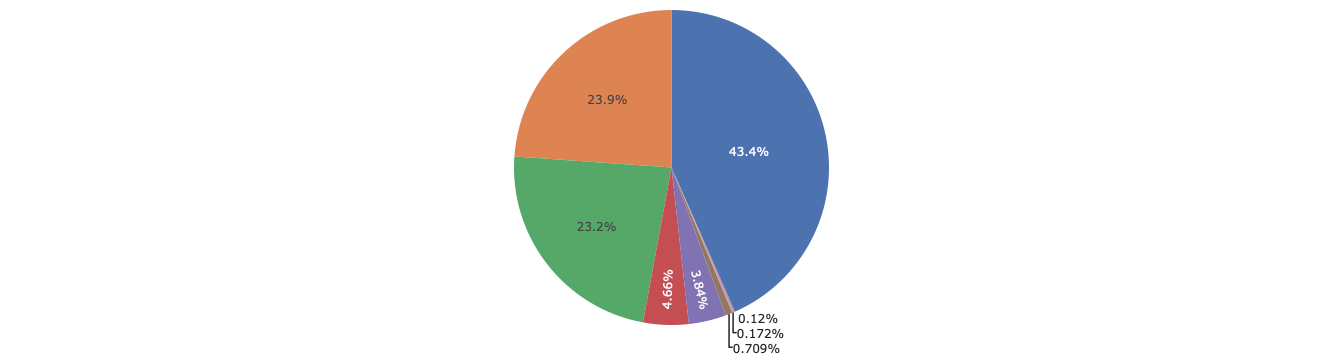

In [16]:
#need to fix the ordering of br values and drop null
props = sfh['br'].value_counts(dropna=True, normalize=True)*100
f1=px.bar(props, x='br', labels=dict(index="Number of Bedrooms", br="Percent"),
            width=350, height=250)
f2 = px.pie(props, values='br', 
            width=350, height=250)
f2

#fig = left_right(f1, f2, width=600, height=200, horizontal_spacing=0.2)
#fig

It's hard to judge the angles in the pie, but the added percentages help us. The advantage of a pie chart over a bar chart here is not clear, especially since we need to rely on the annotations of the percentages to make comparisons.

However, pie charts with only a few pieces can provide effective comparisons when we have multiple pies. For example, the set of six pie charts on the left in the figure below display the proportion of two-bedroom houses sold in each of six citites in the San Francisco East Bay. The pies are ordered according to the proportion. Which is better, the set of six pie charts or the bar chart on the right? A case can be made for each. But, sticking with the bar chart will generally always be at least as clear as any pie chart.

In [17]:
# need to produce a grid of pie charts, one for each city
sfh_cities["2BR"] = sfh_cities["br"] == 2

#f1 = px.pie(sfh_cities, names='2BR',
#       width=350, height=250)
f2 = px.pie(sfh_cities[sfh_cities["city"] == "Piedmont"], names='2BR', color = '2BR',
       width=350, height=250)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_73125/310317423.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Yet, if we use a bar plot instead, the differences are just as easy, if not easier, to compare.

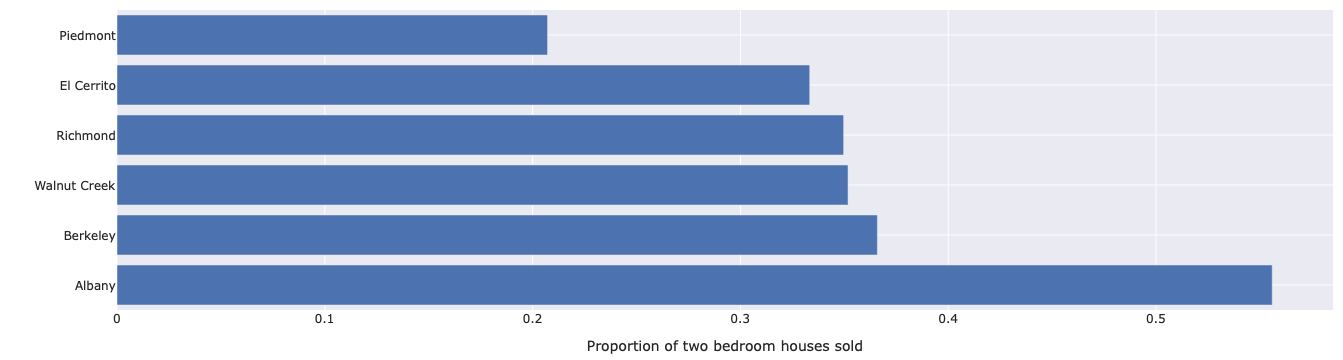

In [18]:
labels = {'2BR': 'Proportion of two bedroom houses sold', 'city': ''}
two_br = sfh_cities.groupby('city')[['2BR']].mean().reset_index() 
fig = px.bar(two_br.sort_values('2BR', ascending=False),
            x='2BR', y='city', labels=labels)
fig

This section covered principles that help visualizations facilitate meaningful comparisons. We saw that it's important to choose plots that emphasize the important differences. We made recommendations for ordering categories in plots--order box plots by medians and bar plots by height. That is of course, if the categories are nominal in nature. If they are ordinal than it's typically best to keep that ordering in the plot. We recommended that when you choose a plot, to make accurate and easy comparisons, it's preferable is the plot uses positions along a common scale, or, if not that, use a plot where comparisons are on identical, nonaligned scales. We provided guidelines for selecting color palettes according to the type of data plotted, and warned against stacking. In the next section, we'll talk about how to incorporate the data design in a visualization.